## Import libraries. 

In [1]:
# External libraries. 
import  numpy;
import  matplotlib.pyplot   as plt;
import  matplotlib          as mpl;
import  seaborn;
import  torch;
from    scipy               import  interpolate;

# Python libraries. 
from    typing              import  List, Dict, Tuple;

## Import my code

### Model Class

Define a class that can describe the right-hand side of a DDE, 
$$x'(t) = F(x(t), y(t), t) $$

In our case, the right-hand side we want to learn will be
1. $F(x, y, t) = x(1 - y) $
2. $F(x, y, t) = \sin{x}$

The `Model` class defines an object that can act like the function $F$.

### DDE Solver

This is an algorithm to solve a DDE of the following form:
$$\begin{aligned} x'(t) &= F(x(t), x(t - \tau), t) \qquad t \in [0, T] \\
x(t) &= x_0 \qquad \qquad \qquad \qquad \quad  t \in [-\tau, 0] \end{aligned}$$

We find an approximate solution using a forward euler solver for DDEs.

### NDDE class

Here we define the `NDDE_1D` class. This class acts as a wrapper around a `Model` object. Recall that a `Model` object acts like the function $F$ in the following DDE:
$$\begin{aligned} x'(t) &= F(x(t), x(t - \tau), t) \qquad t \in [0, T] \\
x(t) &= x_0 \qquad \qquad \qquad \qquad \quad  t \in [-\tau, 0] \end{aligned}$$
The `NDDE_1D` class accepts a `Model`. Its forward method solves the implied DDE on the interval $[0, T]$ and then returns the result.

### Loss

The `Loss_Fn` defines the loss we try to minimize. Currently, this is just the MSE between the predicted and target trajectory.

In [6]:
from    Model   import  Logistic_Model      as Model;
from    Solver  import  RK2                 as DDE_Solver;
from    NDDE    import  NDDE_1D;
from    Loss    import  SSE_Loss            as Loss_Fn;
from    Loss    import  l;
from    Train   import  Train;
from    Utils   import  Initialize_Logger, Initialize_MPL;

# logger setup.
import  logging;

Initialize_Logger(level = logging.INFO);
LOGGER : logging.Logger = logging.getLogger(__name__);

# plot setup. 
Initialize_MPL();


### Generate Target Trajectory

Generate the target trajectory and plot it!

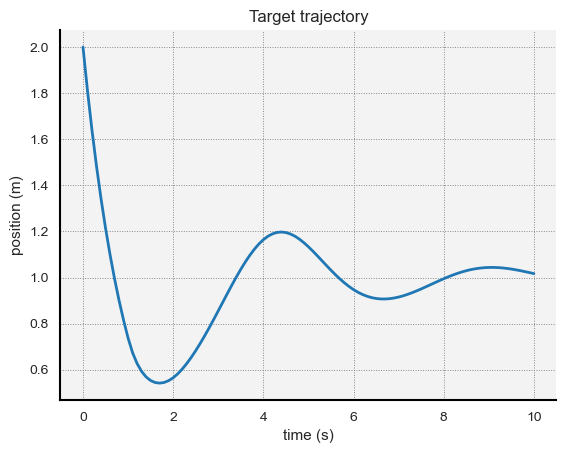

In [7]:
# Set up the parameters and tau value for the target trajectory.
F_Target        = Model(theta_0 = 1.0, theta_1 = 1.0);
x_0_Target      = torch.tensor([2.0]);
tau_Target      = torch.tensor(1.0);
T_Target        = torch.tensor(10.0);

# Get the target trajectory!
x_Target, t_Target  = DDE_Solver(F = F_Target, x_0 = x_0_Target, tau = tau_Target, T = T_Target);

# Finally, lets plot the target trajectory.
seaborn.lineplot(x = t_Target, y = x_Target.reshape(-1).detach().numpy());
seaborn.despine();
plt.xlabel("time (s)");
plt.ylabel("position (m)");
plt.title("Target trajectory");

### Setup, train the Model 


In [8]:
# Settings for training
N_Epochs        : int       = 1000;
Learning_Rate   : float     = 0.1;

Loss_Threshold  : float     = 0.001;             # Will exit when loss drops below this.

In [11]:
# Set up a NDDE_1D object. We will try to train the enclosed model to match the one we used to generate the above plot.
MODEL       = Model(theta_0 = 1.75, theta_1 = 1.75);
DDE_Module  = NDDE_1D(MODEL);

# Pick a starting position, tau, and x_0
tau     = torch.tensor(1.75,     requires_grad = True);
x_0     = torch.clone(x_0_Target).requires_grad_(True);
T       = torch.clone(T_Target).requires_grad_(False);

# Select the optimizer, number of epochs.
Param_List  : List  = list(MODEL.parameters()) + [tau];
Optimizer           = torch.optim.Adam(Param_List, lr = Learning_Rate);
Scheduler           = torch.optim.lr_scheduler.CosineAnnealingLR(
                                            optimizer   = Optimizer, 
                                            T_max       = N_Epochs, 
                                            eta_min     = Learning_Rate/10.);

# Train!
History_Dict, t_Predict, x_Predict  = Train( 
                                        DDE_Module          = DDE_Module, 
                                        x_0                 = x_0, 
                                        tau                 = tau, 
                                        T                   = T, 
                                        N_Epochs            = N_Epochs, 
                                        x_Target            = x_Target, 
                                        t_Target            = t_Target, 
                                        l                   = l,
                                        Loss_Fn             = Loss_Fn, 
                                        Loss_Threshold      = Loss_Threshold, 
                                        Optimizer           = Optimizer, 
                                        Scheduler           = Scheduler);

  10:   Loss = 30.52304  | tau = 1.65853  | grad tau =  32.85538  | Params = 1.11908, 1.17214  | grad Params =  75.08198,  55.08125
  20:   Loss = 4.78536  | tau = 1.49619  | grad tau =  14.11307  | Params = 0.74679, 0.87714  | grad Params =   6.83298, -11.66320
  30:   Loss = 7.80872  | tau = 1.28594  | grad tau =   0.70193  | Params = 0.59480, 0.81655  | grad Params = -17.81461, -70.53639
  40:   Loss = 3.87597  | tau = 1.19165  | grad tau =   0.24265  | Params = 0.58845, 0.93004  | grad Params = -19.29728, -36.00890
  50:   Loss = 1.95631  | tau = 1.14446  | grad tau =   1.88750  | Params = 0.64465, 1.04858  | grad Params = -12.91953,  -5.87335
  60:   Loss = 1.95923  | tau = 1.08899  | grad tau =   2.41040  | Params = 0.70932, 1.10431  | grad Params =  -8.31087,   6.12952
  70:   Loss = 1.67027  | tau = 1.02521  | grad tau =   1.30571  | Params = 0.76557, 1.10639  | grad Params =  -7.07298,   8.29868
  80:   Loss = 1.06015  | tau = 0.98452  | grad tau =  -0.55747  | Params = 0.8161

2024-01-30 19:36:11,442 | Train.py:Train:131 | INFO - Final values:
2024-01-30 19:36:11,442 | Train.py:Train:132 | INFO - tau = 0.99423, c_0 = 1.00243, c_1 = 1.00258


converged after 146 epochs


### Plot results 

We plot the loss history, final vs true trajectory, and the loss function for fixed parameter values as a function of $\tau$

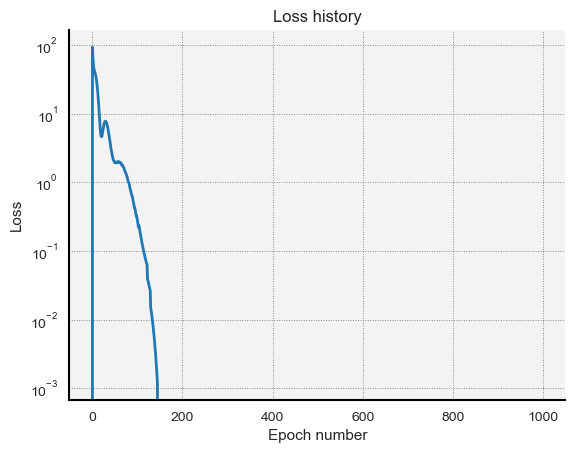

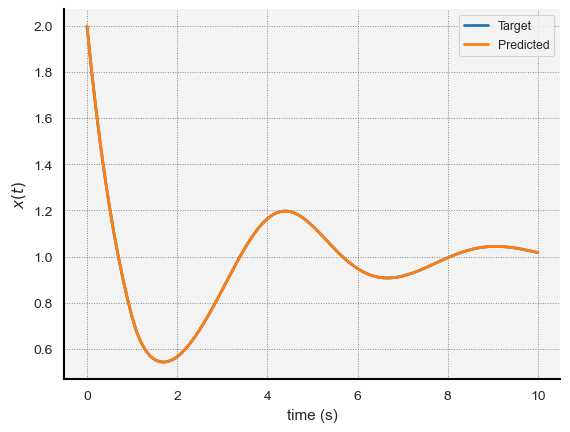

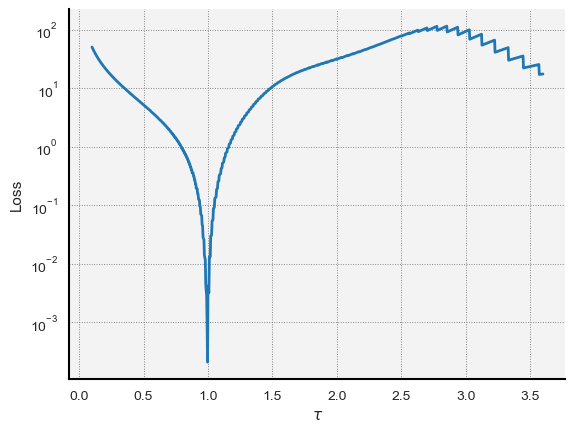

In [13]:
####################################################################################################
# Lost loss history

plt.figure(0);
plt.plot(History_Dict["Loss"].detach().numpy());
seaborn.despine();
plt.xlabel("Epoch number");
plt.ylabel("Loss");
plt.yscale("log");
plt.title("Loss history");



####################################################################################################
# Plot target, final trajectory

plt.figure(1);
plt.plot(t_Target,  x_Target[0].detach().numpy(),      label = "true");
plt.plot(t_Predict, x_Target[0].detach().numpy(),   label = "discovered");
seaborn.despine();
plt.xlabel("time (s)");
plt.ylabel(r"$x(t)$");
plt.legend(["Target","Predicted"]);



####################################################################################################
# Plot loss as a function of tau

# Build initial model
G = Model(theta_0 = 1.0, theta_1 = 1.0);

# Set up a grid of tau values. We will find the loss at each one.
N_Steps : int = 1000;
grid_tau = torch.linspace(0.1, 3.6, steps = N_Steps, requires_grad = True);
Loss_tau = torch.zeros(N_Steps);

for i in range(N_Steps):
    # Find predictions for ith tau value.
    Predictions_i : torch.Tensor = DDE_Solver(G, x_0, grid_tau[i], T)[0];

    # Interpolate true solution on the time step grid for this solution.
    N_i                 : int           = Predictions_i.shape[1];
    x_Interp                            = interpolate.interp1d(t_Target.detach().numpy(), x_Target.detach().numpy());
    t_Values            : numpy.ndarray = numpy.linspace(start = 0, stop = T.item(), num = N_i);
    Targets_i           : torch.Tensor  = torch.from_numpy(x_Interp(t_Values));
    
    # Compute loss
    Loss_tau[i] = Loss_Fn(Predictions_i, Targets_i, t_Values);

# Plot!
plt.figure(2);
seaborn.lineplot(x = grid_tau.detach().numpy(), y = Loss_tau.detach().numpy());
seaborn.despine();
plt.xlabel(r"$\tau$");
plt.ylabel("Loss");
plt.yscale("log");